# Imports

In [1]:
import requests
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn import over_sampling as os 

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
plt.style.use('dark_background')

# Datos de dominancia CoinMarketCap

In [14]:
start, end = "2015-01-01", "2022-01-13"

url = "https://web-api.coinmarketcap.com/v1.1/cryptocurrency/quotes/historical"
start, end = start+' 00:00:00+00:00', end+' 00:00:00+00:00'
params = {"aux":"search_interval,market_cap" , "format":"chart",  "include_global":"true", 
          "id":"1", "interval":"1d", "time_end":end, "time_start":start}

data = requests.get(url, params)
dominance = pd.DataFrame(data.json()['data']).T
dominance['btc_dom'] = dominance['1']/dominance['global']
dominance.index = pd.to_datetime(dominance.index).date

In [25]:
data2 = requests.get(url, params)
# df_test = pd.DataFrame(data.json())
# df_test
import json
with open('data.json', 'w') as f:
    json.dump(data.json(), f)

# Datos de Precios CoinGecko

In [3]:
ticker = 'bitcoin'
url = f"https://api.coingecko.com/api/v3/coins/{ticker}/market_chart"
params = {"vs_currency":"usd", "days":"max"
r = requests.get(url, params).json()
prices = pd.DataFrame(r['prices'])
market_caps = pd.DataFrame(r['market_caps'])
total_volumes = pd.DataFrame(r['total_volumes'])
df = pd.concat([prices, market_caps[1], total_volumes[1]], axis=1)
df[0] = pd.to_datetime(df[0], unit='ms')
df.columns = ['date','price','market_caps','total_volumes']
df.set_index('date', inplace=True)
df.index = pd.to_datetime(df.index).date

# Armo matriz de features

In [5]:
# Junto datos de ambas fuentes

df = df.reset_index()
df = pd.concat([df, dominance], axis=1).dropna()

# Armo matriz de features
features = pd.DataFrame(index=df.index)
features['w_dom_change'] = df.btc_dom.pct_change(7)
features['w_price_change'] = df.price.pct_change(7)
features['w_volume_change'] = df.total_volumes.rolling(7).mean().pct_change(7)
features['w_volatility'] = df.price.pct_change().rolling(7).std()
features['w_ir'] = df.price.pct_change().rolling(7).mean() / df.price.pct_change().rolling(7).std()

features['m_dom_change'] = df.btc_dom.pct_change(30)
features['m_price_change'] = df.price.pct_change(30)
features['m_volume_change'] = df.total_volumes.rolling(30).mean().pct_change(30)
features['m_volatility'] = df.price.pct_change().rolling(30).std()
features['m_ir'] = df.price.pct_change().rolling(30).mean() / df.price.pct_change().rolling(30).std()

# Preparo Target a prededir

Quiero predecir el evento positivo que "Baje mas de 5% la dominancia de BTC los proximos 30 dias, es decir una Alt season mensual"

In [6]:
dias = 30
baja_de_dominancia = 0.05

features['TARGET'] = np.where(df.btc_dom.shift(-dias) - df.btc_dom < - baja_de_dominancia, 1, 0)

# OVER Sampling
Para poder entrenar con un set de datos balanceado, si no, siempre va a predecir que no se da en el proximo mes la gran perdida de dominancia (Alt season)

In [8]:
# Guardo para predecir luego datos actuales
features_ultimos = features.iloc[-30: , :] 

# Preparo Matriz features X, Vector Target y
features = features.dropna().iloc[:-30: , :]

y = features.iloc[:,-1]
X = features.iloc[:,:-1]

X_os, y_os = os.SMOTE(random_state=0).fit_resample(X,y)

ValueError: Found array with 0 sample(s) (shape=(0, 10)) while a minimum of 1 is required.

# Calculo chances previo al FIT

In [ ]:
# Probabilidad que una fecha dada se produzca esa Alt Season en los proximos N (30) dias
features.groupby('TARGET').size()[1] / len(features)

0.1654228855721393

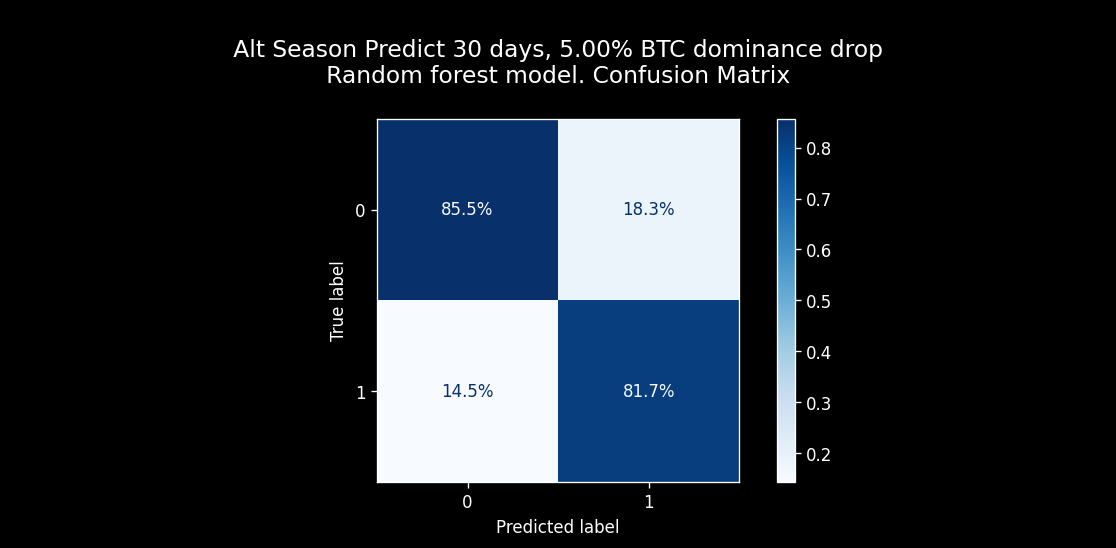

In [ ]:
# Entrenamos con el 60% de los datos al modelo
X_train, X_test, y_train, y_test = train_test_split(X_os, y_os, test_size=0.4)


# Definimos Modelo
modelo = RandomForestClassifier(criterion = 'entropy', max_depth=8, random_state=0, n_estimators=1000) 


# FIT  (Entrenamiento del modelo)
modelo.fit(X_train, y_train)


# Ploteamos Matriz Confusion
plt.rcParams['figure.dpi']  = 120
fig, ax = plt.subplots(figsize=(8,4))
plot_confusion_matrix(modelo, X_test, y_test, values_format='.1%', normalize="pred", cmap='Blues', ax=ax)
sp = ' '*30
title = f'\n{sp}Alt Season Predict {dias} days, {baja_de_dominancia:.2%} BTC dominance drop{sp}'
title += f'\n{sp}Random forest model. Confusion Matrix{sp}\n'
ax.set_title(title, fontsize=14)
plt.show()

# Finalmente, predecimos con datos de ultimo mes


In [ ]:
# Calculo predicciones para el ultimo mes
predicciones = modelo.predict(features_ultimos.iloc[-30:,:-1])

# Veamos que mierda predijo...
print(predicciones)

[1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 1]


In [ ]:
# Calculo el % de días que predijo Alt Season (de los ultimos 30)
modelo.predict(features_ultimos.iloc[-30:,:-1]).sum()/30*100

53.333333333333336

# Conclusión

Mas de la mitad de preducciones positivas (incluyendo los ultimos dias), cuando habíamos dicho que solo había inicialmente un 16.54% de chances de ocurrencia
Con un modelo que cuando predice positivo tiene un 89% de aciertos